# 0. Player's stats from HLTV

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

df = pd.read_csv('../scrape-parse/hltv-stat/stats.csv')
df['rating_1.0_all_Career'] = df['rating_1.0_all_Career'].str[:4]
df['rating_1.0_online_Career'] = df['rating_1.0_online_Career'].str[:4]
df['rating_1.0_lan_Career'] = df['rating_1.0_lan_Career'].str[:4]
df['rating_1.0_major_Career'] = df['rating_1.0_major_Career'].str[:4]

<Axes: >

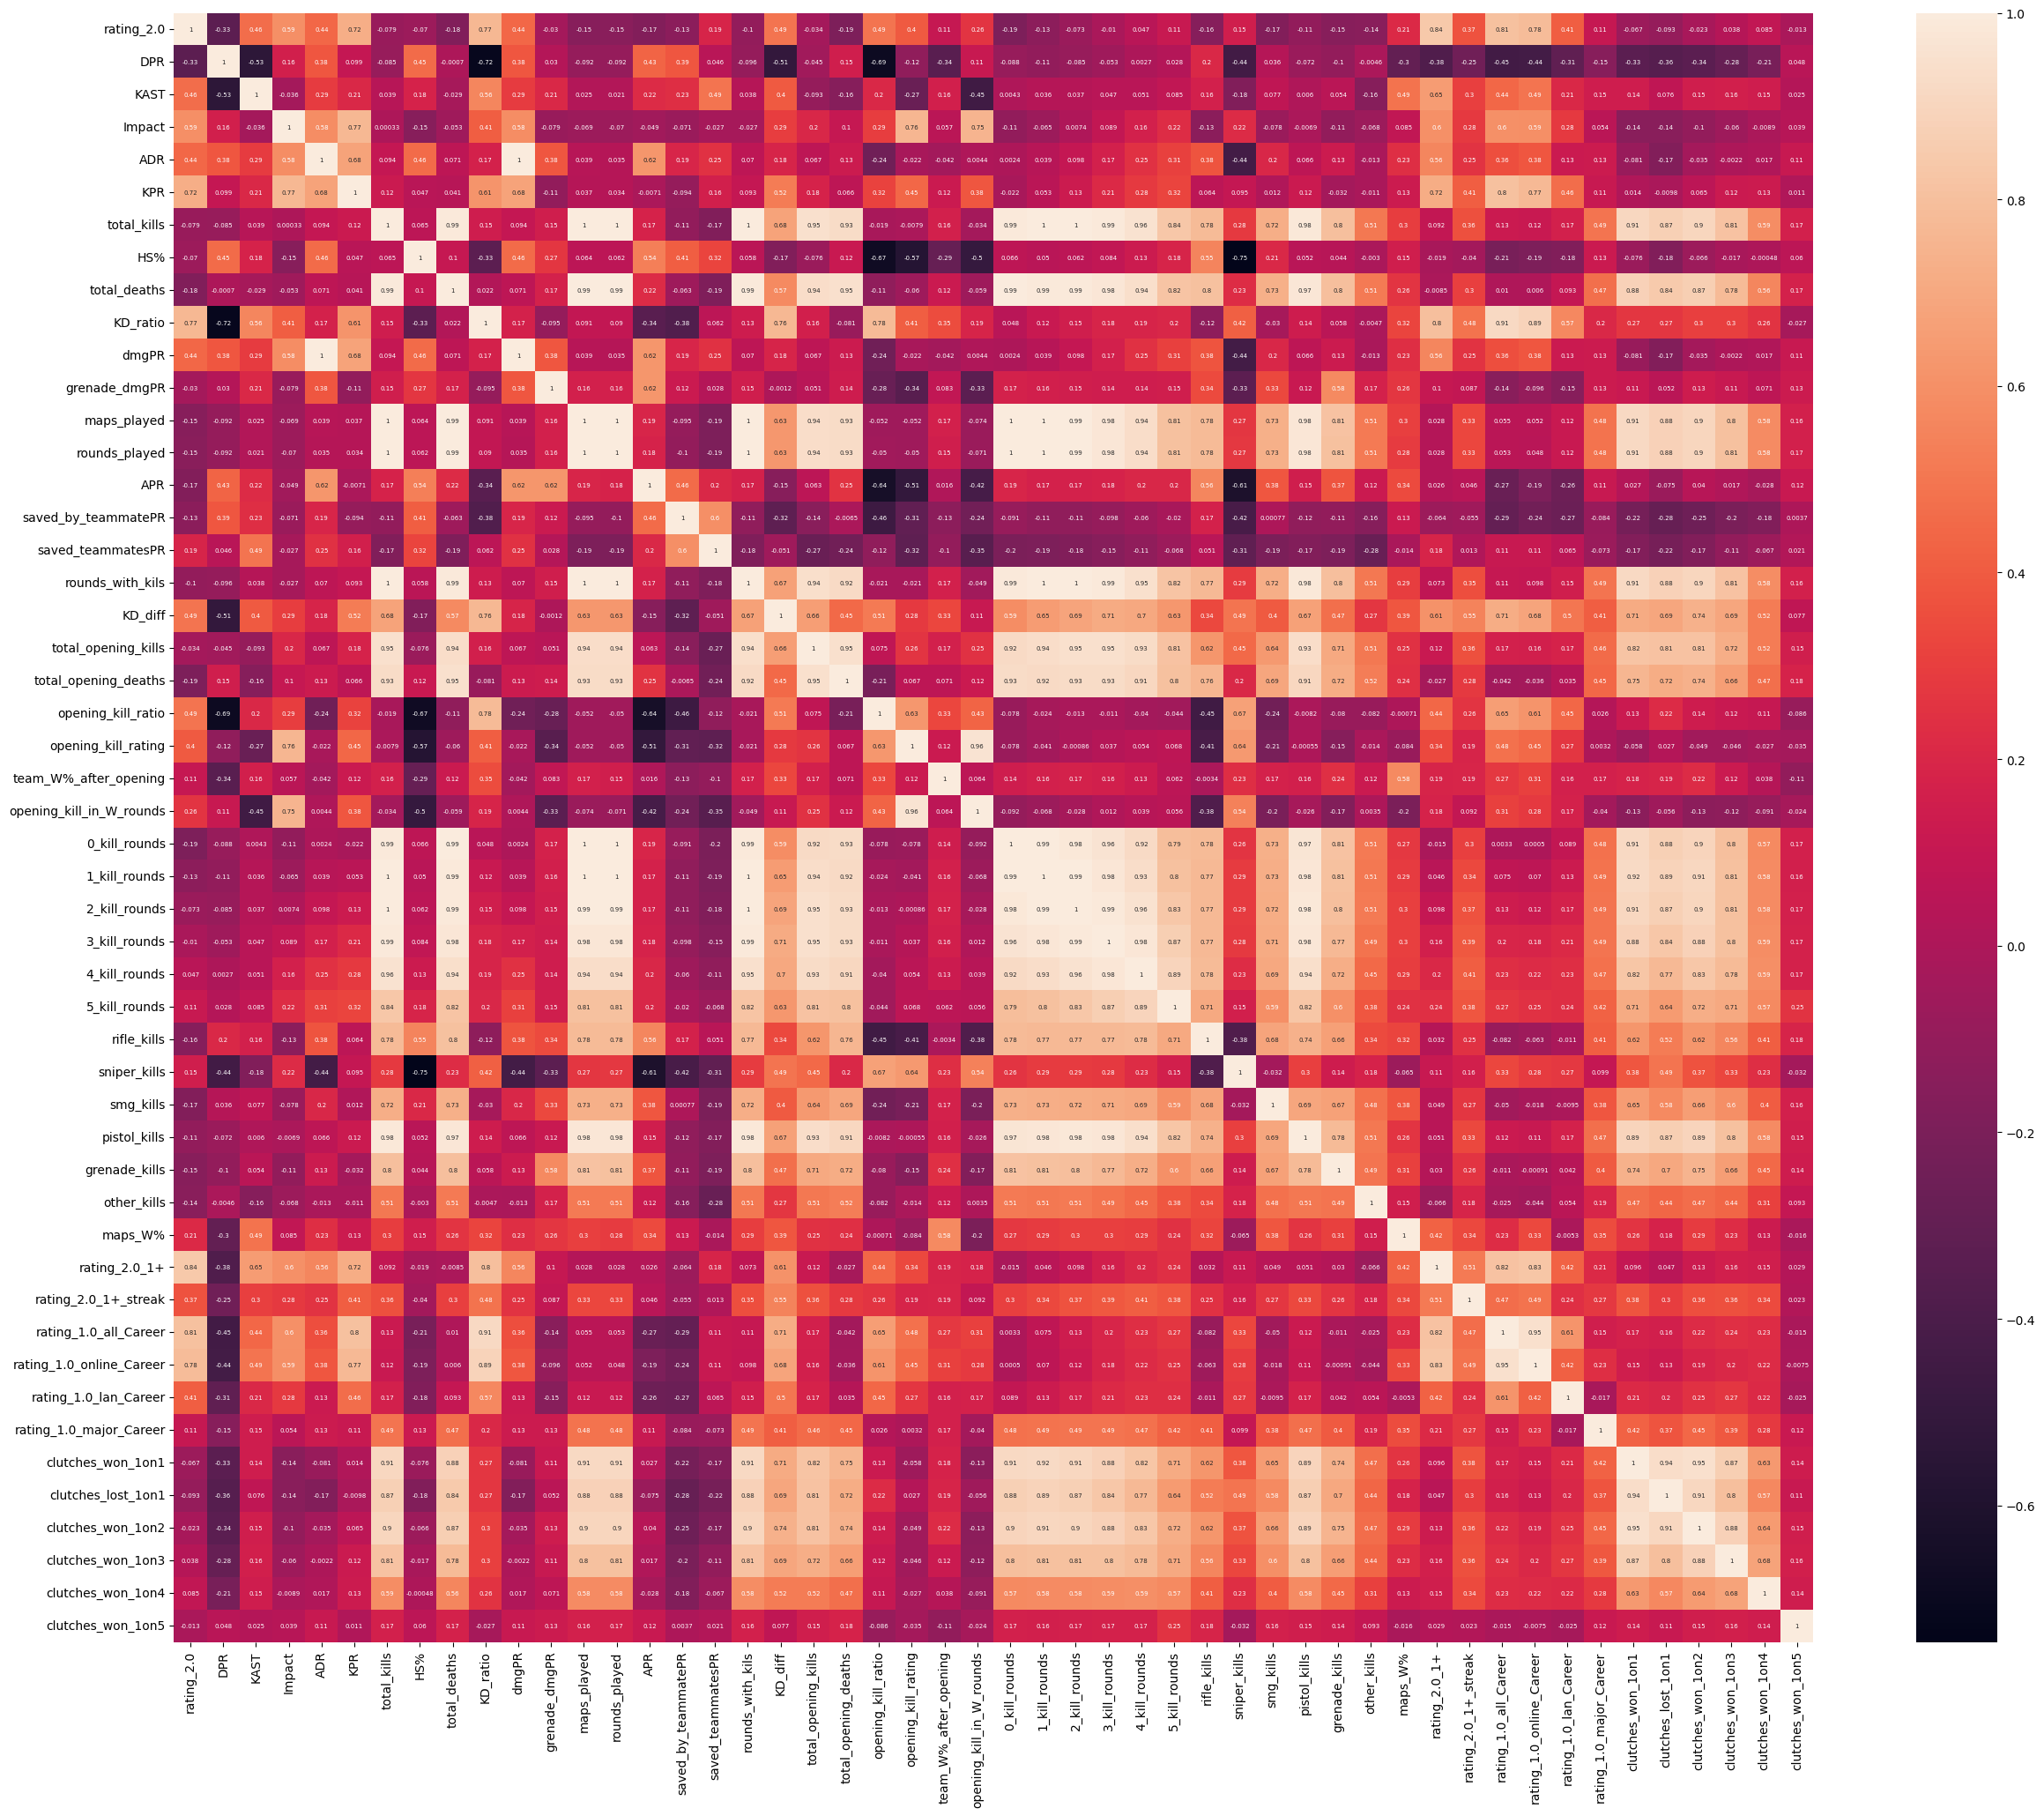

In [6]:
# Heatmap
fig = plt.figure(figsize=(30, 24))
sns.heatmap(df.replace("-","-1").drop(columns=['player_name', 'rating_1.0_data', 'weapon_data']).corr(), annot=True, annot_kws={"fontsize":5})

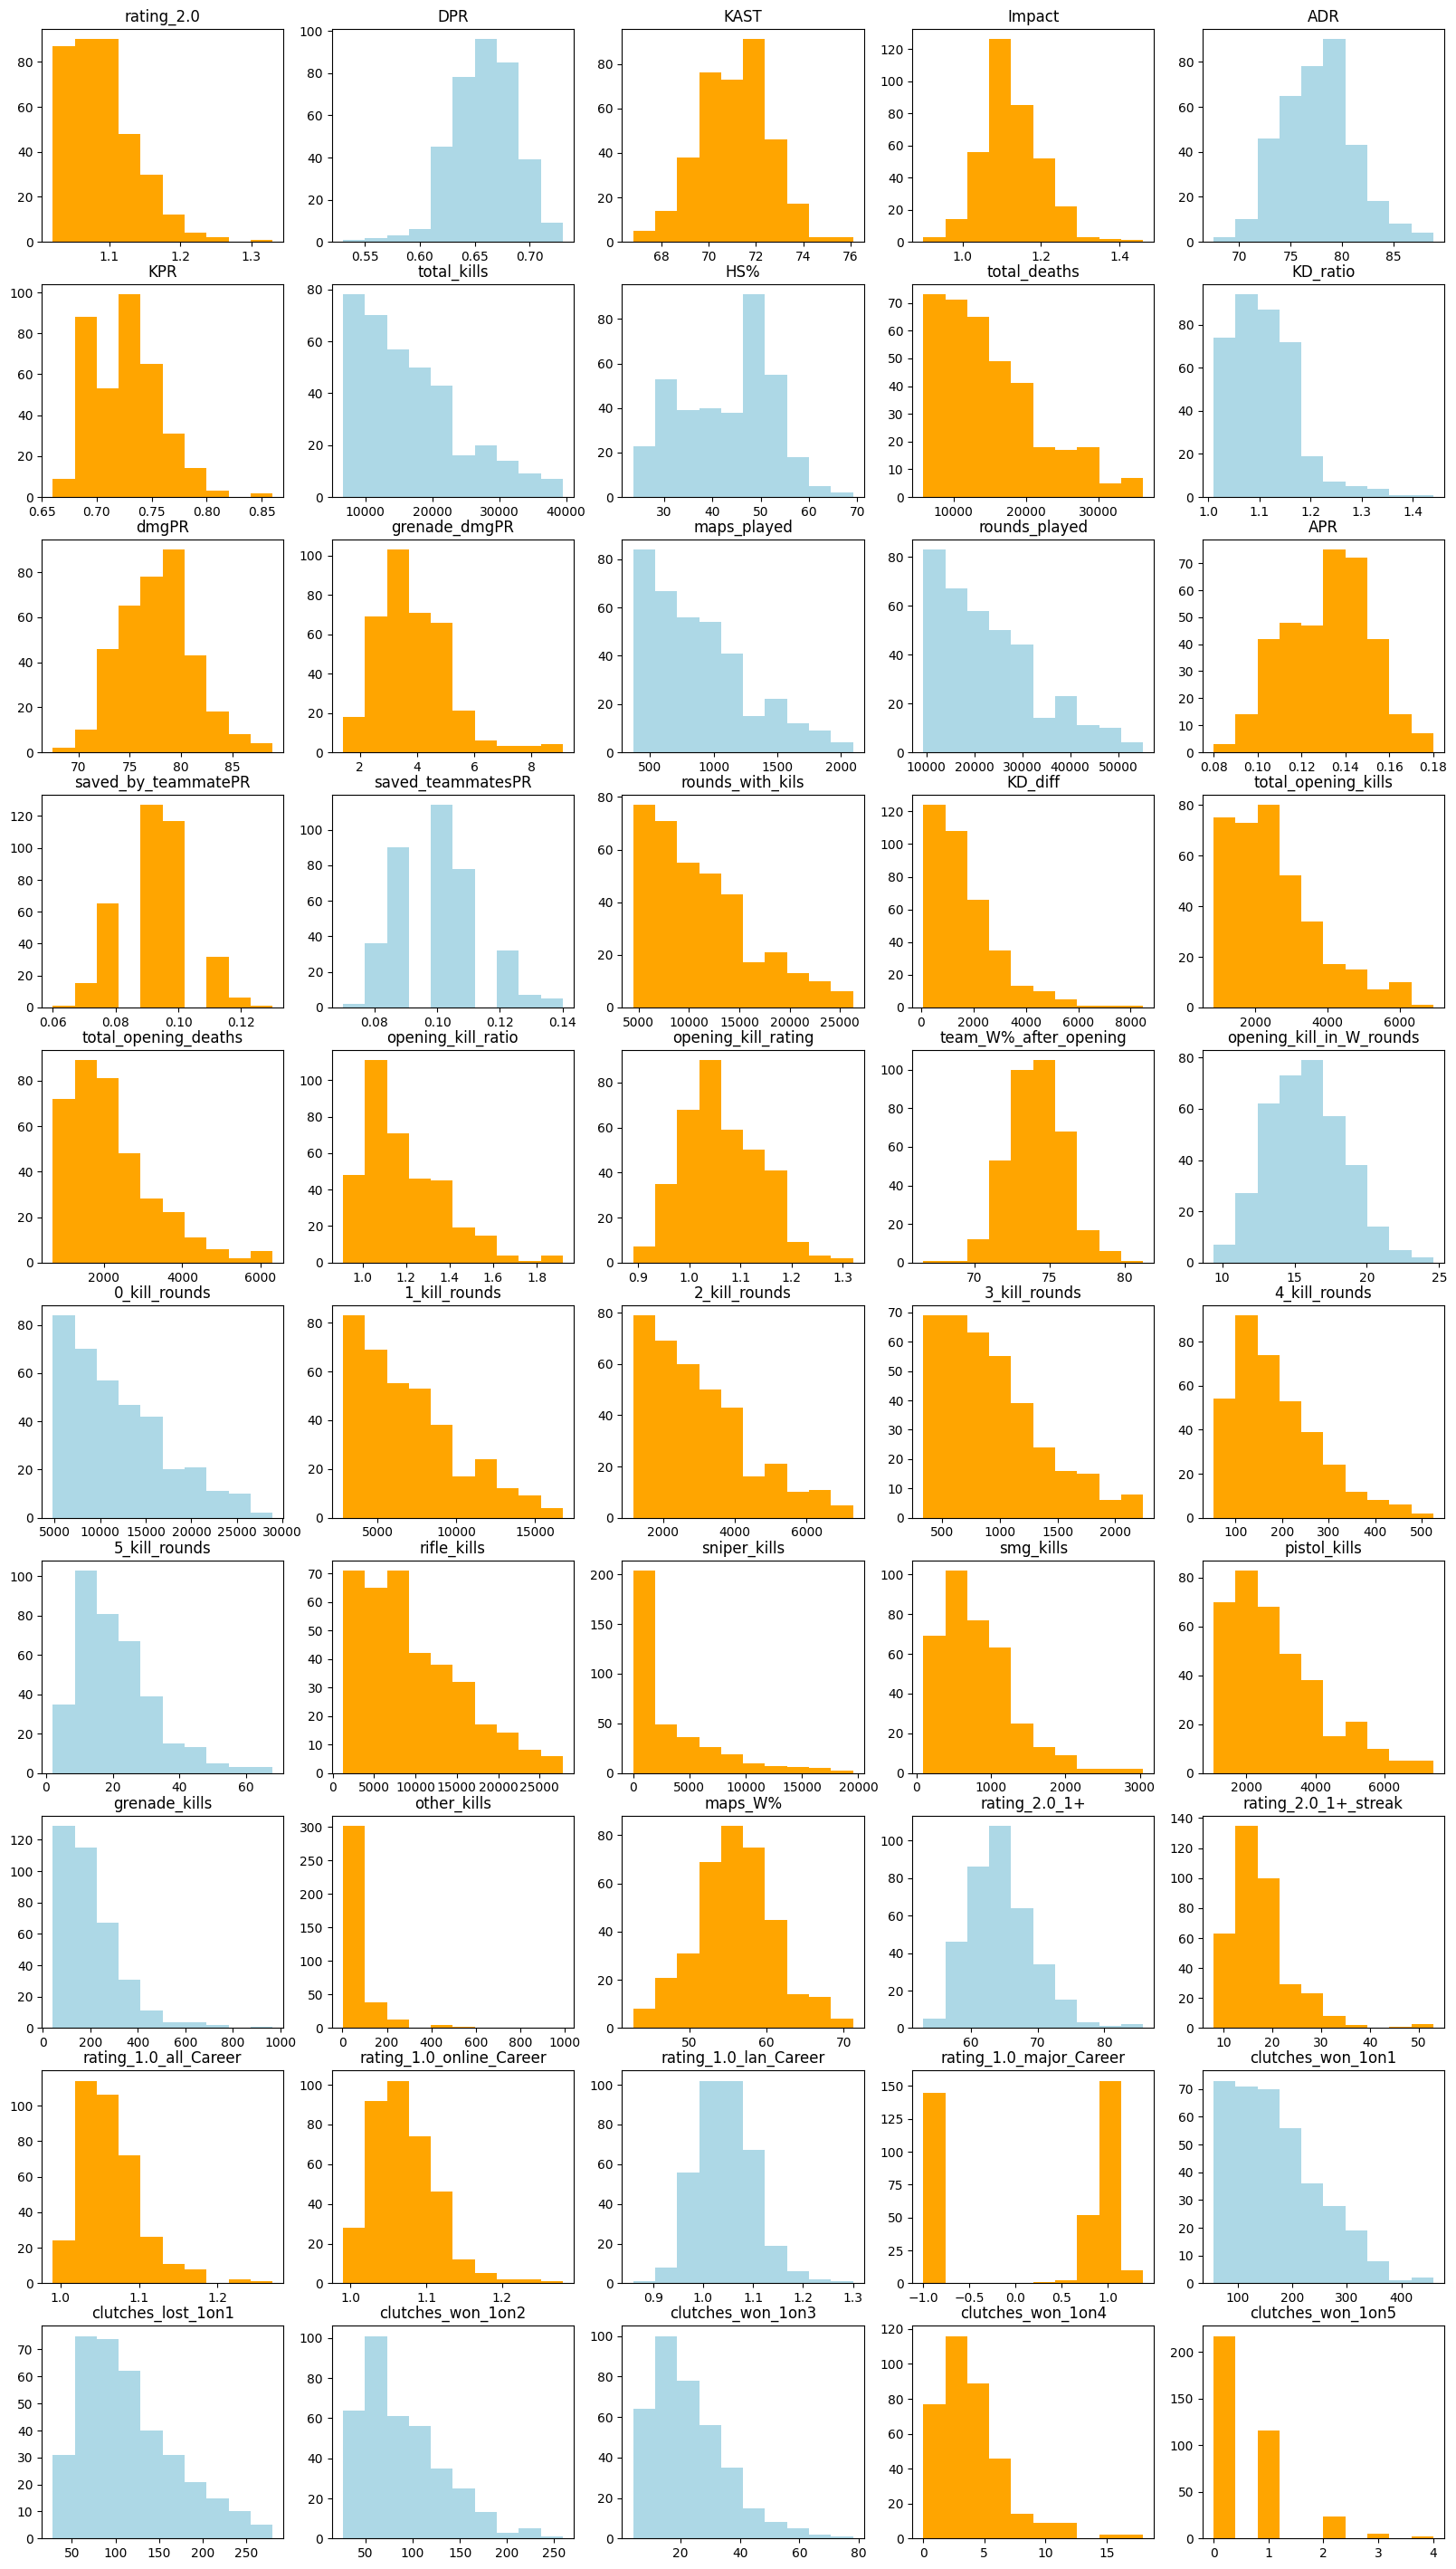

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random


dfnum = df.replace("-","-1").drop(columns=['player_name', 'rating_1.0_data', 'weapon_data']).copy()
columns = dfnum.columns

rowCounter = -1
fig, ax = plt.subplots(ceil(len(columns) / 5), 5, figsize=(20, 36))

colors = ['orange', 'lightblue',]

for idx,column in enumerate(columns):
    if idx % 5 == 0:
        rowCounter += 1
    ax[rowCounter, idx % 5].hist(dfnum[column].astype(float), color=colors[random.randint(0, len(colors)-1)])
    ax[rowCounter, idx % 5].set_title(column)

# 1. Player's statistics from demos

## 1.1 Map-independent stats

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

test = pd.read_csv('../scrape-parse/demo/parse/2022/kills/BLAST-Premier-Fall-Final-2022-faze-vs-heroic-bo3faze-vs-heroic-m1-ancient.dem.csv')
test.columns

Index(['Unnamed: 0', 'tick', 'seconds', 'clockTime', 'attackerSteamID',
       'attackerName', 'attackerTeam', 'attackerSide', 'attackerX',
       'attackerY', 'attackerZ', 'attackerViewX', 'attackerViewY',
       'victimSteamID', 'victimName', 'victimTeam', 'victimSide', 'victimX',
       'victimY', 'victimZ', 'victimViewX', 'victimViewY', 'assisterSteamID',
       'assisterName', 'assisterTeam', 'assisterSide', 'isSuicide',
       'isTeamkill', 'isWallbang', 'penetratedObjects', 'isFirstKill',
       'isHeadshot', 'victimBlinded', 'attackerBlinded', 'flashThrowerSteamID',
       'flashThrowerName', 'flashThrowerTeam', 'flashThrowerSide', 'noScope',
       'thruSmoke', 'distance', 'isTrade', 'playerTradedName',
       'playerTradedTeam', 'playerTradedSteamID', 'playerTradedSide', 'weapon',
       'weaponClass', 'roundNum', 'matchID', 'mapName'],
      dtype='object')

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)

# ---------- Prepare data ---------- #

killdemo = os.listdir('../scrape-parse/demo/parse/2022/kills/')
kills = pd.DataFrame()


for i in range(0,100):
    temp = pd.read_csv('../scrape-parse/demo/parse/2022/kills/' + killdemo[i])
    kills = pd.concat([kills, temp])

kills['attackerName'] = kills['attackerName'].str.strip()
kills = kills.reset_index(drop=True)
kills['one'] = 1
# kills = kills.loc[kills['attackerName'].isna() == False]





# ---------- Player stats ---------- #

players = pd.DataFrame(kills[['attackerName']])
players['attackerName'] = players['attackerName'].str.strip()
players = players.drop_duplicates(subset=['attackerName']).reset_index(drop=True).sort_values(by=['attackerName'])

# Matches played
kills['matches_played'] = kills.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['one'].transform('sum')
kill_test = kills.loc[kills['matches_played'].notna() == True].drop_duplicates(subset=['attackerName'])
players = players.merge(kill_test[['attackerName','matches_played']], on='attackerName', how='left')

# Kill count
kills['kill_count'] = kills.groupby(by=['attackerName'])['one'].transform('sum')
players = players.merge(kills[['attackerName','kill_count']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPM - kills per match
players['KPM'] = players['kill_count'] / players['matches_played']

# KPR - kills per round
rounds = kills[['matchID','roundNum']].sort_values(by=['matchID','roundNum']).drop_duplicates(subset=['matchID'],keep='last').rename(columns={'roundNum':'rounds_played'})
kills = kills.merge(rounds, on='matchID', how='left')
kills['KPM'] = kills[['attackerName','matchID','one']].groupby(by=['attackerName','matchID'])['one'].transform('sum')
kills['KPR_match'] = kills['KPM'] / kills['rounds_played']
kills['KPR'] = kills[['attackerName','KPR_match']].groupby(by=['attackerName'])['KPR_match'].transform('mean')
players = players.merge(kills[['attackerName','KPR']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted KPM
players['weighted_KPM'] = players['KPM'] * (players['matches_played'] / (players['matches_played'].max() - players['matches_played'].min()))

# Headshot %
kills['hs_count'] = kills.groupby(by=['attackerName'])['isHeadshot'].transform('sum')
kills['HS%'] = kills['hs_count'] / kills['kill_count']
players = players.merge(kills[['attackerName','HS%']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted HS%
players['weighted_HS%'] = players['HS%'] * (players['matches_played'] / (players['matches_played'].max() - players['matches_played'].min()))

pd.set_option('display.max_rows', 100)
players.sort_values(by=['weighted_HS%'], ascending=False).head(50)

,attackerName,matches_played,kill_count,KPM,KPR,weighted_KPM,HS%,weighted_HS%
28,Twistzz,26.0,476.0,18.307692,0.769751,19.833333,0.552521,0.598564
19,NiKo,26.0,518.0,19.923077,0.829382,21.583333,0.532819,0.577220
57,jabbi,23.0,411.0,17.869565,0.722093,17.125000,0.593674,0.568938
72,ropz,26.0,473.0,18.192308,0.759572,19.708333,0.505285,0.547393
56,huNter,26.0,471.0,18.115385,0.759544,19.625000,0.503185,0.545117
61,karrigan,26.0,367.0,14.115385,0.607931,15.291667,0.501362,0.543143
71,rain,26.0,432.0,16.615385,0.699854,18.000000,0.488426,0.529128
2,Brollan,23.0,379.0,16.478261,0.678015,15.791667,0.503958,0.482960
36,b1t,19.0,319.0,16.789474,0.731735,13.291667,0.601881,0.476489
75,sjuush,23.0,389.0,16.913043,0.679231,16.208333,0.493573,0.473008


In [7]:
kills.columns

Index(['Unnamed: 0', 'tick', 'seconds', 'clockTime', 'attackerSteamID',
       'attackerName', 'attackerTeam', 'attackerSide', 'attackerX',
       'attackerY', 'attackerZ', 'attackerViewX', 'attackerViewY',
       'victimSteamID', 'victimName', 'victimTeam', 'victimSide', 'victimX',
       'victimY', 'victimZ', 'victimViewX', 'victimViewY', 'assisterSteamID',
       'assisterName', 'assisterTeam', 'assisterSide', 'isSuicide',
       'isTeamkill', 'isWallbang', 'penetratedObjects', 'isFirstKill',
       'isHeadshot', 'victimBlinded', 'attackerBlinded', 'flashThrowerSteamID',
       'flashThrowerName', 'flashThrowerTeam', 'flashThrowerSide', 'noScope',
       'thruSmoke', 'distance', 'isTrade', 'playerTradedName',
       'playerTradedTeam', 'playerTradedSteamID', 'playerTradedSide', 'weapon',
       'weaponClass', 'roundNum', 'matchID', 'mapName', 'one',
       'matches_played', 'kill_count', 'rounds_played', 'KPM', 'KPR_match',
       'KPR'],
      dtype='object')

<Axes: >

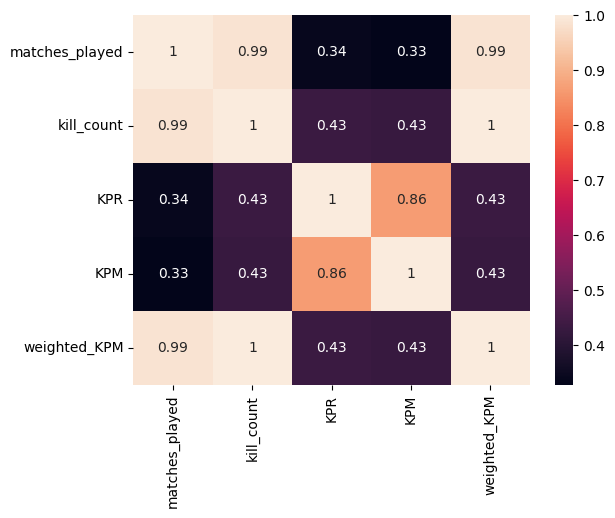

In [7]:
import seaborn as sns

sns.heatmap(players[['matches_played','kill_count','KPR','KPM','weighted_KPM']].corr(), annot=True)

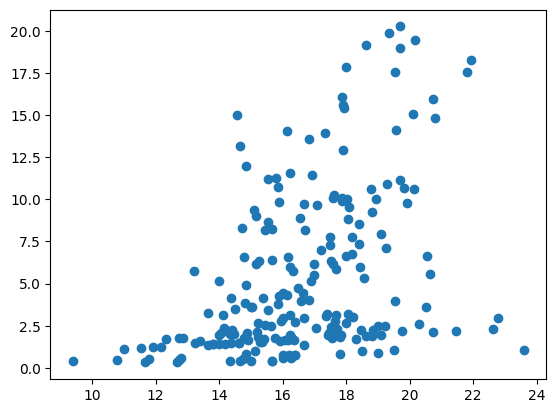

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

players_plot = players.loc[players['attackerName'].notna() == True]

# reg = BayesianRidge()
# reg.fit(players_plot[['matches_played']],players_plot[['KPM']])
# ymean, ystd = reg.predict(players_plot[['matches_played']], return_std=True)

plt.scatter(players_plot['KPM'],players_plot['weighted_KPM'])
# plt.plot(players_plot[['matches_played']],ymean,'r--')
# plt.fill_between(players_plot['matches_played'], ymean-ystd, ymean+ystd, alpha=0.7)
# plt.ylim(0,30)